In [45]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def plot_time_series(time, values, label, smooth=0, repeat=1):
    n = len(time)
    x_and_label = {i: label for i, label in enumerate(time*repeat)}
    update_ticks = lambda x, pos: x_and_label[x] if x in x_and_label.keys() else ""

    values = values * repeat
    time = list(x_and_label.keys())

    if smooth:
        x_new = np.linspace(min(time), max(time), 100)
        spline = make_interp_spline(time, values)
        values = spline(x_new)
        time = x_new

    # plot
    ax = plt.subplot()
    ax.plot(time, values)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    # labels
    ax.set_xlabel("Time", fontsize=10)
    ax.set_ylabel("Value", fontsize=10)
    plt.title(label, fontsize=20)
    plt.grid(True)

In [47]:
from datetime import datetime
from dataclasses import dataclass
from typing import List, Optional

import pandas as pd
import numpy as np 


class Trend:
    def __init__(self, slope: float = 0):
        self.slope = slope

    def get_value(self, start_ts: datetime, ts: datetime, base_value: Optional[float] = 0) -> float:
        x = (ts - start_ts).days
        return base_value + self.slope * x


class Sazonality:
    def __init__(
        self,
        week_days: Optional[List[float]] = None,
        month_period: Optional[List[float]] = None,
        year_months: Optional[List[float]] = None
    ):
        self.week_days = week_days or [1]*7
        self.month_period = month_period or [1]*3
        self.year_months = year_months or [1]*12

    def get_week_days_constant(self, ts: datetime) -> float:
        return self.week_days[ts.weekday()]

    def get_month_period_constant(self, ts: datetime) -> float:
        if ts.day > 20:
            return self.month_period[2]
        if ts.day > 10:
            return self.month_period[1]
        return self.month_period[0]

    def get_year_months_constant(self, ts: datetime) -> float:
        return self.year_months[ts.month - 1]

    def get_constant(self, ts: datetime) -> float:
        return self.get_week_days_constant(ts) * self.get_month_period_constant(ts) * self.get_year_months_constant(ts)


class Noise:
    def __init__(self, mean: float = 1, var: float = 0, seed: Optional[int] = None, generator = None):
        self.generator = generator or np.random.default_rng(seed=seed)
        self.mean = mean
        self.var = var

    def generate(self) -> float:
        return self.generator.normal(loc=self.mean, scale=self.var)


@dataclass(frozen=True)
class TimeSeries:
    date_points: np.ndarray
    value_points: np.ndarray
#     trend_points: np.ndarray
#     sazonality_points: np.ndarray
#     noise_points: np.ndarray


class TimeSeriesGenerator:
    def __init__(
        self,
        trend: Optional[Trend] = None,
        sazonality: Optional[Sazonality] = None,
        noise: Optional[Noise] = None,
    ):
        self.trend = trend or Trend()
        self.sazonality = sazonality or Sazonality()
        self.noise = noise or Noise()

    def generate(self, start_date: datetime, base_value: float, n: int) -> "TimeSeriesGenerator":
        date_points = pd.date_range(
            datetime(year=2021, month=1, day=1), periods=n
        ).to_list()
        start_ts = date_points[0]

        trend_points = np.fromiter(
            (
                trend_spec.get_value(
                    start_ts=start_ts , ts=ts, base_value=base_value
                ) for ts in date_points
            ),
            dtype=float
        )
        sazonality_points = np.fromiter(
            (self.sazonality.get_constant(ts) for ts in date_points),
            dtype=float
        )
        noise_points = np.fromiter(
            (self.noise.generate() for ts in date_points),
            dtype=float
        )
        value_points = trend_points * sazonality_points * noise_points
        return TimeSeries(date_points=date_points, value_points=value_points)


In [48]:
start_ts = datetime(year=2021, month=1, day=1)
date_points = pd.date_range(start_ts, periods=50).to_list()
type(date_points[0])

pandas._libs.tslibs.timestamps.Timestamp

In [49]:
week_labels = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
week_sazonality = [0.85, 0.9, 1, 1, 0.9, 0.8, 0.8]

month_labels = ["begin", "middle", "end"]
month_sazonality = [1, 0.9, 1]

year_labels = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
year_sazonality = [1, 0.95, 0.9, 0.9, 0.85, 0.85, 0.85, 0.85, 0.9, 0.9, 0.95, 1]

sazonality_spec = Sazonality(
    week_days=week_sazonality,
    #month_period=month_sazonality,
    year_months=year_sazonality
)

trend_spec = Trend(slope=5)

noise_spec = Noise(var=0.05)

time_series_generator = TimeSeriesGenerator(
    trend=trend_spec,
    sazonality=sazonality_spec,
    #noise=noise_spec
)


In [50]:
time_series = time_series_generator.generate(
    start_date=datetime(year=2020, month=1, day=1),
    base_value=1000,
    n=365*3
)

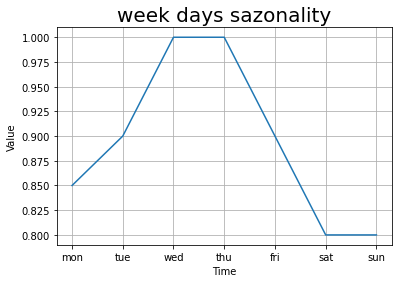

In [51]:
# show week sazonality
plot_time_series(
    time=week_labels,
    values=week_sazonality,
    label="week days sazonality",
)

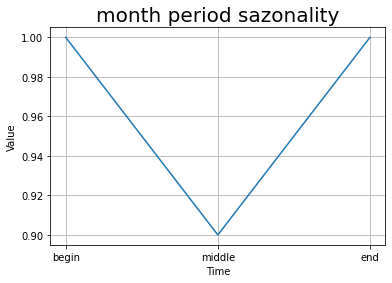

In [52]:
# show month sazonality
plot_time_series(
    time=month_labels,
    values=month_sazonality,
    label="month period sazonality",
)

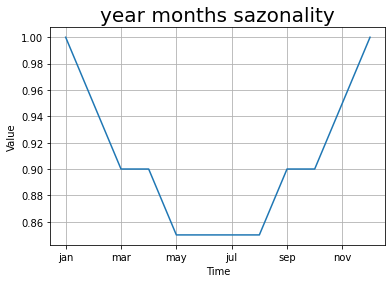

In [53]:
# show year sazonality
plot_time_series(
    time=year_labels,
    values=year_sazonality,
    label="year months sazonality",
)

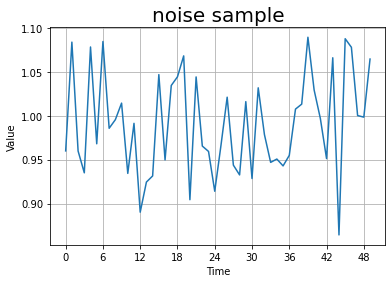

In [54]:
# show noise sample
plot_time_series(
    time=[i for i in range(50)],
    values=[noise_spec.generate() for i in range(50)],
    label="noise sample",
)

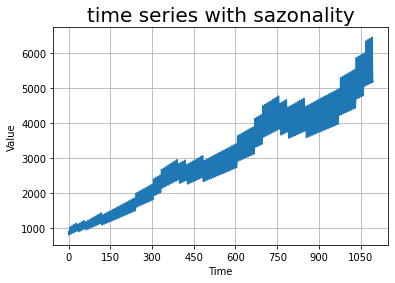

In [55]:
# show time series
plot_time_series(
    time=[i for i, _ in enumerate(time_series.date_points)],
    values=time_series.value_points,
    label="time series with sazonality"
)

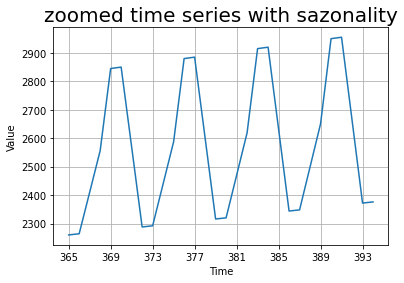

In [56]:
# show zoomed time series

plot_time_series(
    time=[i for i, _ in enumerate(time_series.date_points)][365:395],
    values=time_series.value_points[365:395],
    label="zoomed time series with sazonality"
)

## Forecasting/Anomally Detection Libs

In [57]:
import pandas as pd
from prophet import Prophet

df = pd.DataFrame(
    {"ds": time_series.date_points, "y": time_series.value_points}
)
df_train = pd.DataFrame(
    {"ds": time_series.date_points[:875],
     "y": time_series.value_points[:875]}
)

In [58]:
model = Prophet(
    seasonality_mode="multiplicative",
)

In [59]:
model.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.012


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3930.56   0.000138043        101.91       0.308           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3932.02    0.00116282       386.553           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3932.99   7.42639e-06       201.836      0.4006      0.4006      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3933.33   3.69487e-05       79.3227           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3935.66    0.00063028       458.239      0.8074      0.8074      619   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     556     

In [60]:
future = model.make_future_dataframe(periods=1, include_history=False)

In [61]:
future

,ds
0,2023-05-26


In [62]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2023-05-26,4100.203747,4061.069526,4138.721525


In [63]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-05-26,4263.824106,4061.069526,4138.721525,4263.824106,4263.824106,-0.038374,-0.038374,-0.038374,0.00856,0.00856,0.00856,-0.046934,-0.046934,-0.046934,0.0,0.0,0.0,4100.203747


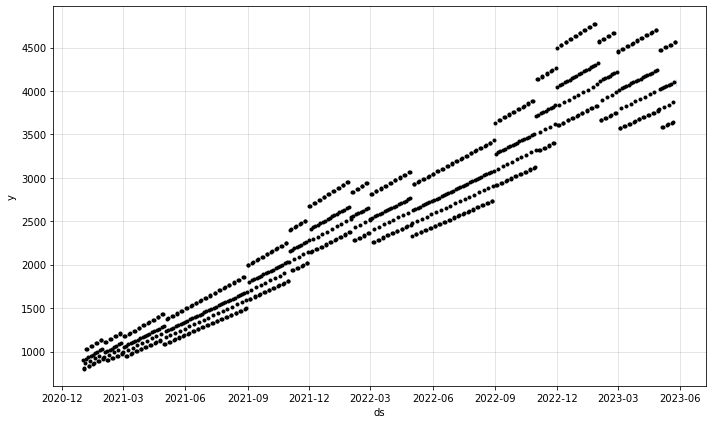

In [64]:
fig1 = model.plot(forecast)

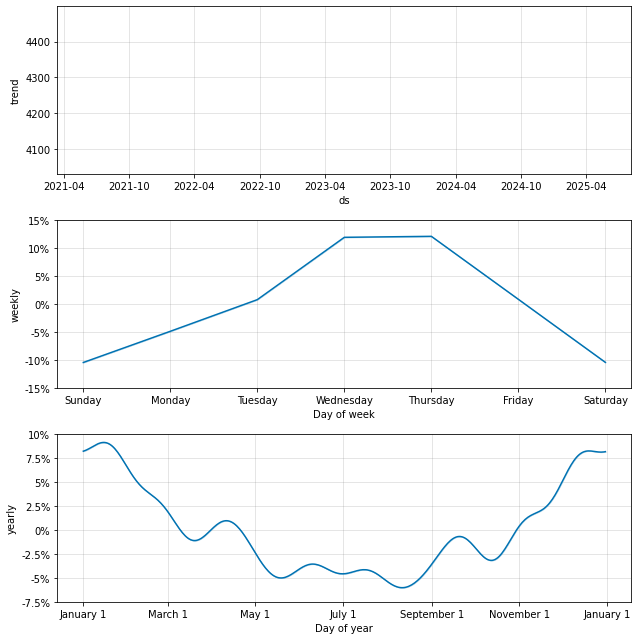

In [65]:
fig2 = model.plot_components(forecast)

ValueError: x and y must have same first dimension, but have shapes (0,) and (60,)

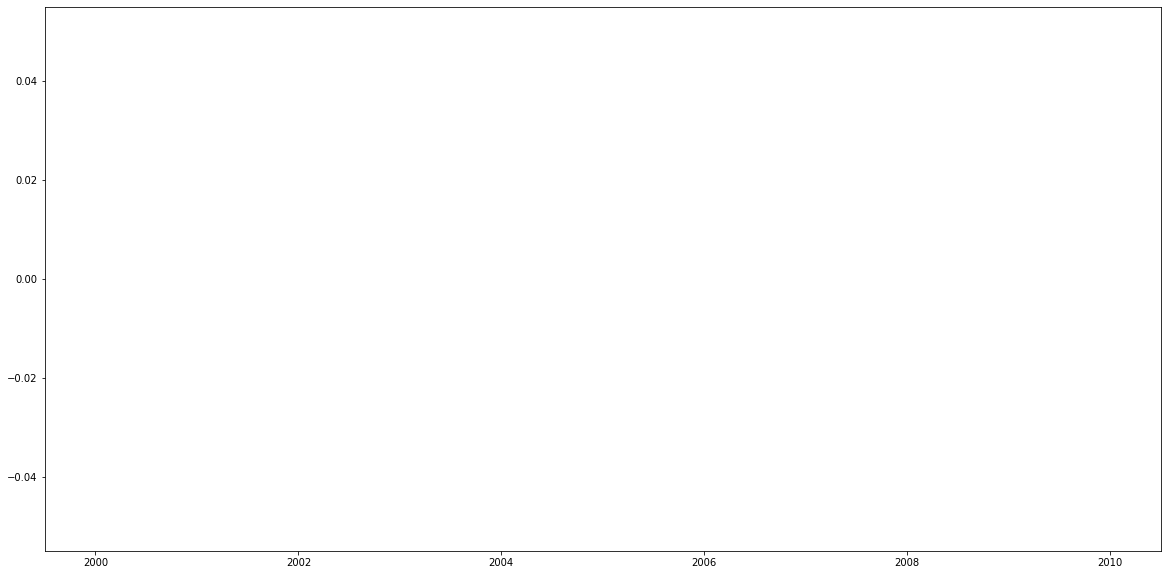

In [66]:
def plot_compare_predict_and_time_series(forecast_pdf, unseen_n, ts, lower_bound = None, upper_bound = None):
    plt.figure(figsize=(20,10))
    plt.plot(
        forecast_pdf["ds"][lower_bound:upper_bound-unseen_n + 1],
        forecast_pdf["yhat"][lower_bound:upper_bound-unseen_n + 1],
        label="forecast-train",
    )
    plt.plot(
        forecast_pdf["ds"][upper_bound-unseen_n:upper_bound],
        forecast_pdf["yhat"][upper_bound-unseen_n:upper_bound],
        label="forecast-unseen",
    )
    plt.fill_between(
        x=forecast_pdf["ds"][lower_bound:upper_bound],
        y1=forecast_pdf["yhat_lower"][lower_bound:upper_bound],
        y2=forecast_pdf["yhat_upper"][lower_bound:upper_bound],
        alpha=0.3,
        label="uncertainty interval"
    )
    plt.plot(forecast_pdf["ds"][lower_bound:upper_bound], ts.value_points[lower_bound:upper_bound], label="real value")
    plt.legend()
    plt.show()

lower_bound = 830
upper_bound = 890
plot_compare_predict_and_time_series(
    forecast_pdf=forecast,
    unseen_n=15,
    ts=time_series,
    lower_bound=lower_bound,
    upper_bound=upper_bound
)



In [ ]:
def absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred) / y_true)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(absolute_percentage_error(y_true, y_pred)))

def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))

In [ ]:
mean_absolute_percentage_error(forecast["yhat"], time_series.value_points[:890])

In [ ]:
max_absolute_percentage_error(forecast["yhat"], time_series.value_points[:890])

In [ ]:
percentage_errors = absolute_percentage_error(forecast["yhat"], time_series.value_points[:890])
percentage_errors.sort()
plt.hist(percentage_errors, bins=20)

In [ ]:
np.percentile(percentage_errors, 75)

In [ ]:
np.percentile(percentage_errors, 95)

In [ ]:
np.percentile(percentage_errors, 99)

## Neural Prophet

In [68]:
from neuralprophet import NeuralProphet
model = NeuralProphet(
    seasonality_mode="multiplicative",
)
model.fit(df_train, freq="D")

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 36
INFO:nprophet.config:Auto-set epochs to 36


/Users/temp/.pyenv/versions/3.9.6/envs/jenny-3.9.6/lib/python3.9/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")
INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[36/36]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.15it/s, SmoothL1Loss=4.6e-5, MAE=29.7, RegLoss=0]


,SmoothL1Loss,MAE,RegLoss
0,1.022313,5899.650190,0.0
1,0.246530,2386.938700,0.0
2,0.041517,981.171140,0.0
3,0.005265,329.459246,0.0
4,0.001473,174.648420,0.0
5,0.000452,92.236364,0.0
6,0.000177,57.955717,0.0
7,0.000166,56.698354,0.0
8,0.000189,62.095216,0.0
9,0.000236,68.537607,0.0


In [90]:
model.make_future_dataframe(df_train, n_historic_predictions=len(df_train["ds"]))

,ds,y,t,y_scaled
0,2021-01-01,900.0000,0.000000,0.123084
1,2021-01-02,804.0000,0.001144,0.100000
2,2021-01-03,808.0000,0.002288,0.100962
3,2021-01-04,862.7500,0.003432,0.114127
4,2021-01-05,918.0000,0.004577,0.127412
...,...,...,...,...
871,2023-05-22,3868.9875,0.996568,0.836997
872,2023-05-23,4100.4000,0.997712,0.892642
873,2023-05-24,4560.2500,0.998856,1.003216
874,2023-05-25,4564.5000,1.000000,1.004238


In [92]:
predict_df = df_train[["ds"]]
predict_df["y"] = np.nan
model.predict(model.make_future_dataframe(predict_df, n_historic_predictions=len(predict_df["ds"])))

/Users/temp/.pyenv/versions/3.9.6/envs/jenny-3.9.6/lib/python3.9/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2021-01-01,NaN,921.799377,NaN,859.441895,0.122785,0.009519
1,2021-01-02,NaN,864.422607,NaN,862.725342,0.122994,-0.119418
2,2021-01-03,NaN,867.691345,NaN,866.008789,0.123159,-0.119638
3,2021-01-04,NaN,901.819336,NaN,869.292114,0.123281,-0.055680
4,2021-01-05,NaN,937.064880,NaN,872.575562,0.123357,0.009762
...,...,...,...,...,...,...,...
871,2023-05-22,NaN,3768.257568,NaN,4214.997559,-0.061057,-0.055680
872,2023-05-23,NaN,4015.397705,NaN,4218.317383,-0.062741,0.009762
873,2023-05-24,NaN,4499.246582,NaN,4221.637207,-0.064325,0.136741
874,2023-05-25,NaN,4504.686523,NaN,4224.957031,-0.065808,0.138714


In [93]:
model.predict(model.make_future_dataframe(df_train, n_historic_predictions=len(df_train["ds"]))[:-1])

/Users/temp/.pyenv/versions/3.9.6/envs/jenny-3.9.6/lib/python3.9/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2021-01-01,900.0000,921.799377,21.799377,859.441895,0.122785,0.009519
1,2021-01-02,804.0000,864.422607,60.422607,862.725342,0.122994,-0.119418
2,2021-01-03,808.0000,867.691345,59.691345,866.008789,0.123159,-0.119638
3,2021-01-04,862.7500,901.819336,39.069336,869.292114,0.123281,-0.055680
4,2021-01-05,918.0000,937.064880,19.064880,872.575562,0.123357,0.009762
...,...,...,...,...,...,...,...
870,2023-05-21,3638.0000,3527.581787,-110.418213,4211.677734,-0.059278,-0.119638
871,2023-05-22,3868.9875,3768.257568,-100.729932,4214.997559,-0.061057,-0.055680
872,2023-05-23,4100.4000,4015.397705,-85.002295,4218.317383,-0.062741,0.009762
873,2023-05-24,4560.2500,4499.246582,-61.003418,4221.637207,-0.064325,0.136741
